In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 19

### Simple RNN 

Changes for the Assignment

- Tensorflow
- **FIFA Dataset**
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**
- ADAM
- Mini Batch
- L2 regularization
- ${Swish}$ Activation function

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

%matplotlib inline

2023-12-09 20:17:04.972254: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 20:17:04.975239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 20:17:05.016184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 20:17:05.016217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 20:17:05.016240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 200 # number of epochs
ALPHA = 0.01 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
TRAIN_SIZE = 14496 # Fix size of train set so that we have batches of same size
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

### Dataset
##### - Weather History

In [4]:
data_df=pd.read_csv('weatherHistory.csv')

In [5]:
data_df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'],utc=True)

In [7]:
data_df.drop('Formatted Date',axis=1,inplace=True)

In [8]:
data_df

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.,2016-09-09 17:00:00+00:00
96449,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.,2016-09-09 18:00:00+00:00
96450,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.,2016-09-09 19:00:00+00:00
96451,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.,2016-09-09 20:00:00+00:00


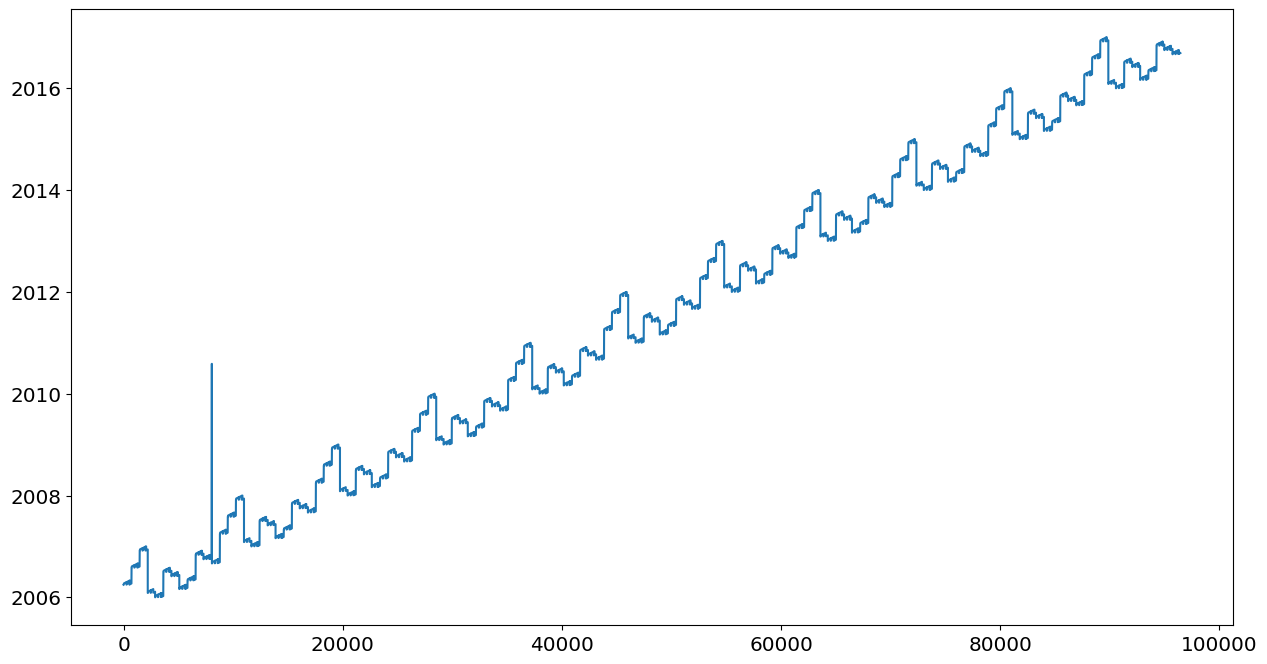

In [9]:
plt.plot(data_df['datetime']);

In [10]:
temp_df = data_df[['datetime','Temperature (C)']]
temp_df = temp_df.sort_values(by='datetime',axis=0,ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [11]:
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [12]:
temp_df.reset_index(drop=True, inplace = True)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [13]:
temp_df.describe()

,temp
count,96453.000000
mean,11.932678
std,9.551546
min,-21.822222
25%,4.688889
50%,12.000000
75%,18.838889
max,39.905556


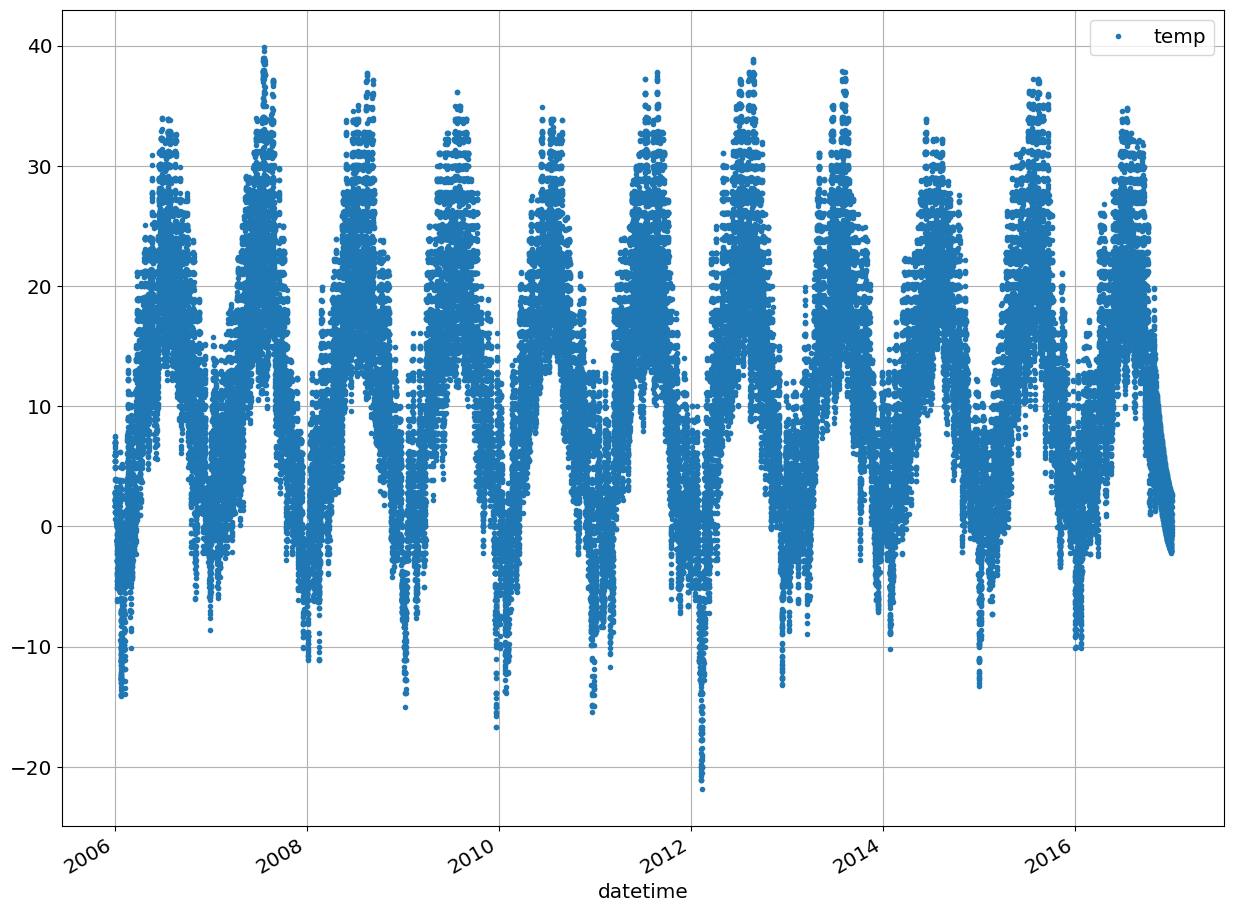

In [14]:
fig, ax = plt.subplots(figsize = (15,12))
temp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [15]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   datetime  96453 non-null  datetime64[ns, UTC]
 1   temp      96453 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 1.5 MB


In [17]:
features_df = temp_df['datetime'][:24]
label_df = temp_df['temp'][:24]
features_df.shape, label_df.shape

((24,), (24,))

In [18]:
features_df, label_df

(0    2005-12-31 23:00:00+00:00
 1    2006-01-01 00:00:00+00:00
 2    2006-01-01 01:00:00+00:00
 3    2006-01-01 02:00:00+00:00
 4    2006-01-01 03:00:00+00:00
 5    2006-01-01 04:00:00+00:00
 6    2006-01-01 05:00:00+00:00
 7    2006-01-01 06:00:00+00:00
 8    2006-01-01 07:00:00+00:00
 9    2006-01-01 08:00:00+00:00
 10   2006-01-01 09:00:00+00:00
 11   2006-01-01 10:00:00+00:00
 12   2006-01-01 11:00:00+00:00
 13   2006-01-01 12:00:00+00:00
 14   2006-01-01 13:00:00+00:00
 15   2006-01-01 14:00:00+00:00
 16   2006-01-01 15:00:00+00:00
 17   2006-01-01 16:00:00+00:00
 18   2006-01-01 17:00:00+00:00
 19   2006-01-01 18:00:00+00:00
 20   2006-01-01 19:00:00+00:00
 21   2006-01-01 20:00:00+00:00
 22   2006-01-01 21:00:00+00:00
 23   2006-01-01 22:00:00+00:00
 Name: datetime, dtype: datetime64[ns, UTC],
 0     0.577778
 1     1.161111
 2     1.666667
 3     1.711111
 4     1.183333
 5     1.205556
 6     2.222222
 7     2.072222
 8     2.200000
 9     2.733333
 10    2.788889
 11    3.82

In [19]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, 
                                                    train_size=23)

In [20]:
y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy()  #convert to array

In [21]:
y_train

array([2.22222222, 4.93333333, 1.20555556, 2.73333333, 2.2       ,
       6.20555556, 4.95555556, 2.07222222, 2.78888889, 7.43888889,
       4.91111111, 3.82222222, 5.42222222, 5.47222222, 5.47222222,
       6.95      , 1.18333333, 1.16111111, 5.97222222, 5.90555556,
       0.57777778, 1.71111111, 1.66666667])

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

<img src='../../images/dnn_nb_s05_fig2.png' width = '500' alt = 'Session 5 fig 2'/>

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log(\hat{y_i}) + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log(\hat{y}_i) + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

## Predict Function

For predictions, we will simply be using the forward propagation.

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Prepare Model:

In [22]:
h_units = 100

input_shape = (1,10000)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                  input_shape = input_shape,
                                  activation = 'tanh'))

model.add(tf.keras.layers.Dense(units=1,
                               activation='linear'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               1010100   
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1010201 (3.85 MB)
Trainable params: 1010201 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [25]:
X_train[:1].shape

(1,)

In [26]:
X_train.shape

(23,)

In [27]:
predict = model(X_train[:1])
predict

ValueError: Exception encountered when calling layer 'sequential' (type Sequential).

Input 0 of layer "simple_rnn" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (1,)

Call arguments received by layer 'sequential' (type Sequential):
  • inputs=6   2006-01-01 05:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]
  • training=None
  • mask=None

In [28]:
predict.numpy().sum()

NameError: name 'predict' is not defined

In [29]:
tf.nn.softmax(predict).numpy().sum()

NameError: name 'predict' is not defined

In [30]:
model.compile(optimizer='adam',
             loss=loss_function,
             metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, 
                    validation_data= [X_test, y_test],
                    epochs=EPOCHS, 
                    verbose= 2,
                    batch_size = BATCH_SIZE,
                    )

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [32]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

NameError: name 'history' is not defined

NameError: name 'loss_df' is not defined

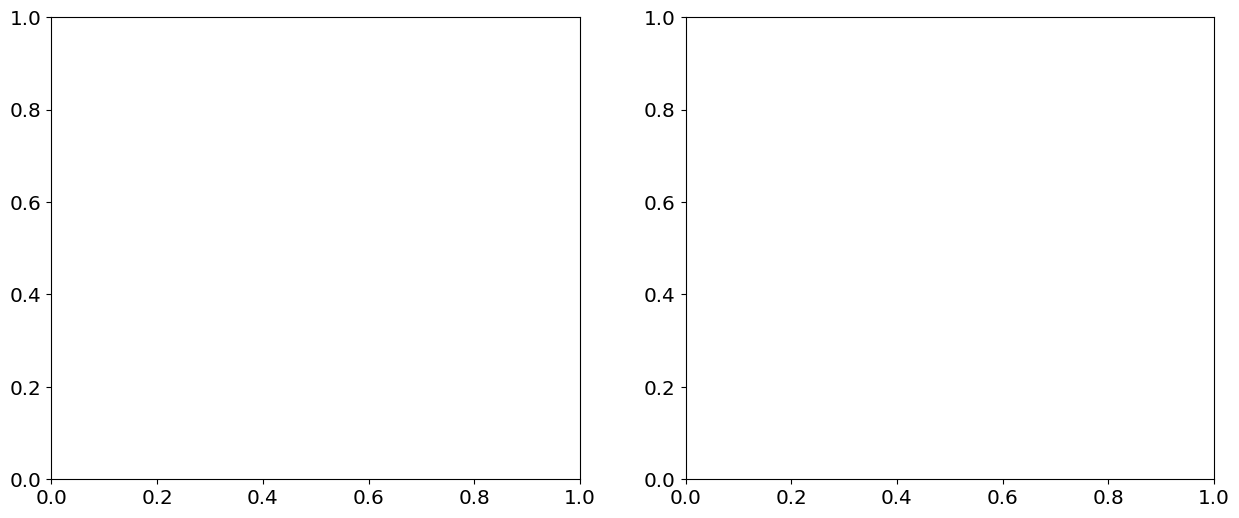

In [33]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]


ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot(y = [y1,y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();


y1 = loss_df.columns[1]
y2 = loss_df.columns[3]

ax = axes[1]

loss_df.plot(y = [y1,y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
model

In [ ]:
predict_model = model
predict_model.add(tf.keras.layers.Softmax(axis=1))
predict_model.summary()

In [ ]:
loss_df = pd.DataFrame(loss_hist)

In [ ]:
33*18+18

In [ ]:
loss_df.head()

In [ ]:
model.summary()

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]

loss_df[250:].plot(x = 'epoch', y = ['loss', 't_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['loss', 't_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[-l_range]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['t_loss'] == (loss_df['t_loss'].min())]

## Predictions
### Train Data

In [ ]:
# def fn_m
# ake_predicitions(pred_func, X_train):
#     y_pred = pred_func(X)
#     return y_pred

In [ ]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

### Test Data

In [ ]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=labels.values()
                             )

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();